In [2]:
# Imports
%config InlineBackend.figure_format = 'retina'
%pylab inline
import sys
sys.path.append('../../src/')
from helpers import *
from plothelpers import *
from AdditiveBaseGame import *
from random import sample
import json, pickle
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# Preprocess

In [2]:
# Migrate data
freqs = { 7: range(1,15), 8: [1, 1.5, 2, 3] }
for base in [7,8]:
    for freq in freqs[base]:
        res = pickle.load(open(f'HUR05/HUR05-base-{base}-freq-{freq}.pickle', 'rb'))
        fav_bases = array(res[0])
        
        # For some reason, init base 7 also includes counts for base 5 
        # (which cannot occur)
        if base == 7:
            fav_bases = fav_bases[:,:,:,1:]

        successes = array(res[1])
        base_counts = fav_bases.sum(axis=2)
        num_bases = fav_bases.sum(axis=3).sum(axis=2)
        num_unique_bases = (fav_bases.sum(axis=2) > 0).sum(axis=2)

        _base = os.path.join('../../results/HUR05/', f'HUR05-base-{base}-freq-{freq}')
        np.save(_base+'-base-counts.npy', base_counts, allow_pickle=False)
        np.savetxt(_base+'-num-bases.txt.gz', array(num_bases))
        np.savetxt(_base+'-num-unique-bases.txt.gz', array(num_unique_bases))
        np.savetxt(_base+'-successes.txt.gz', array(successes))
        
        params = json.load(open(f'HUR05/HUR05-base-{base}-freq-{freq}-setup.json', 'r'))
        json.dump(params, open(_base+'-params.json', 'w'))
        

In [54]:
# Preprocess raw data
freqs = { 7: range(1,15), 8: [1, 1.5, 2,3] }
directory = '../../results/HUR05/'
data, cols = [], []
for base in [7,8]:
    for freq in freqs[base]:
        res = load_ABG_simulation(directory, f'HUR05-base-{base}-freq-{freq}')
        base_counts, num_bases, num_unique_bases, successes, params = res
        params = load_ABG_simulation(directory, 
                    f'HUR05-base-{base}-freq-{freq}', params_only=True)
        bases = list(params['bases'])
        
        # Turn into dataframe
        df = pd.DataFrame([
            num_bases.mean(axis=0).T.tolist(),
            num_bases.std(axis=0).T.tolist(),
            num_unique_bases.mean(axis=0).T.tolist(),
            num_unique_bases.std(axis=0).T.tolist(),
            successes.mean(axis=0).T.tolist(),
            successes.std(axis=0).T.tolist()]
            +base_counts.mean(axis=0).T.tolist()
            +base_counts.std(axis=0).T.tolist()).T
        
        # columns
        df.columns = pd.MultiIndex.from_tuples([
            ['num_bases', 'mean'], ['num_bases', 'std'],
            ['num_unique_bases', 'mean'], ['num_unique_bases', 'std'],
            ['successes', 'mean'], ['successes', 'std']
        ] + [(f'base-{b}', 'mean') for b in bases]
          + [(f'base-{b}', 'std') for b in bases])
        
        # Index
        if base == 8: 
            df = df.loc[arange(0,2500,10),:] #lower resolution
        df.index = arange(0, 25000, 100)
        df = df.reindex_axis(sorted(df.columns), axis=1)
        df.to_csv(directory + f'HUR05-base-{base}-freq-{freq}.csv')
        
        # Combine in one big df
        columns = [b for b in df.columns.levels[0] if b.startswith('base-')]
        subdf = df[columns]
        data += subdf.values.T.tolist()
        cols += [[f'init-base-{base}', f'freq-{freq}']+list(col) 
                 for col in subdf.columns.tolist()]

# Export full dataframe
data = pd.DataFrame(data).T
data.columns = pd.MultiIndex.from_tuples(cols)
data.index = df.index
data.to_csv('HUR05.csv')
data.to_csv(directory + 'HUR05.csv')

# Plot

In [3]:
data = pd.read_csv('HUR05.csv', index_col=0, header=[0,1,2,3])
params = load_ABG_simulation('', 'HUR05-base-7-freq-1', params_only=True)

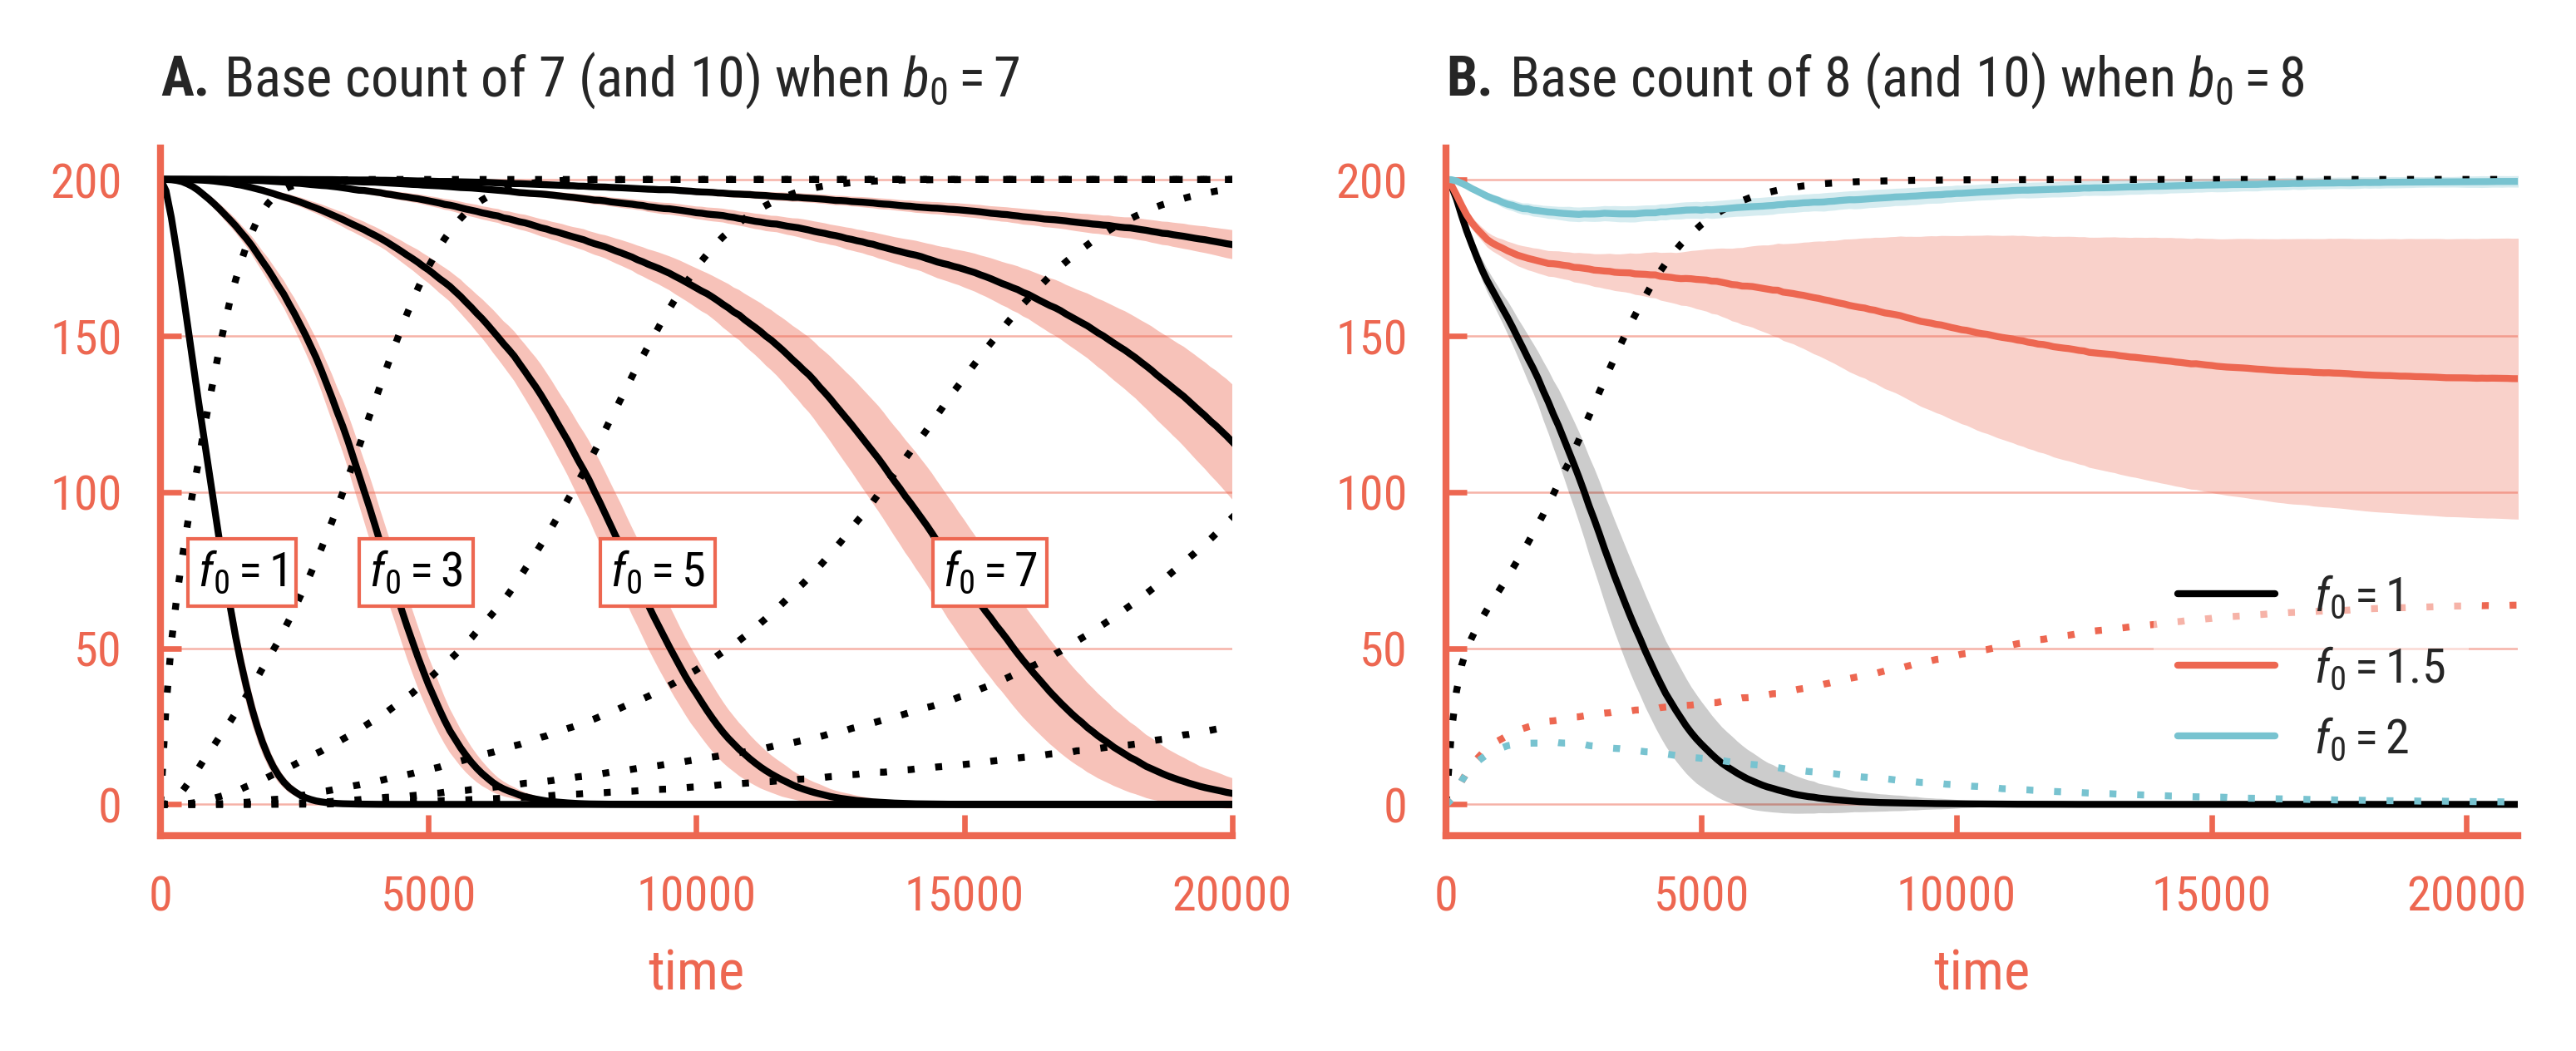

In [22]:
# Plot!
figure(figsize=cm2inch(12,3.5))

# FIGURE B
if True:
    ax1 = subplot(121)
    xs = data.index

    for freq in [1,3,5,7,9,11]:
        # Base 7 counts
        df7 = data['init-base-7'][f'freq-{freq}']['base-7']
        plot(xs, df7['mean'], 'k')
        fill_between(xs, df7['mean']-.5*df7['std'], df7['mean']+.5*df7['std'], 
                alpha=.4, facecolor=get_color('orange'))

        # Base 10 counts
        df10 = data['init-base-7'][f'freq-{freq}']['base-10']
        plot(xs, df10['mean'], 'k', dashes=(1,3))

        if freq < 9:
            x = abs(df7['mean'] - 70).argmin() - 500
            y = df7['mean'][x]
            text(x, 70, f'$f_0={freq}$', fontsize=7, color = 'black',
                    bbox={'facecolor':'white', 'pad':1.5, 'edgecolor':'#ed6751', 'linewidth':.5})
    
    title('Base count of 7 (and 10) when $b_0 = 7$')   
    xlim(0,20000)
    ylim(-10,210)
    xlabel('time')


# FIGURE A
if True:
    ax2 = subplot(122)
    xs =  arange(0,25000,100)

    # Settings
    colors = {1: '#000000', 1.5: '#ed6751', 2: '#78C3D0'}
    labels = {8: {1: '$f_0 = 1$', 1.5: '$f_0 = 1.5$', 2: '$f_0=2$'}, 
              10: {1: '', 2:'', 1.5:''}}
    dashes = {8: (), 10: (1,3)}
    alphas = {1: .2, 1.5: .3, 2:.3 }

    def show_results(freq, show_std=True):
        for base in [8,10]:
            df = data['init-base-8'][f'freq-{freq}'][f'base-{base}']
            means = df['mean']
            std = df['std']
            plot(xs, means, label=labels[base][freq], dashes=dashes[base],
                 color=colors[freq])

            if show_std and base != 10:
                fill_between(xs, means-.5*std, means+.5*std, 
                             alpha=alphas[freq], facecolor=colors[freq], edgecolor='#ffffff')

    # Plot!
    show_results(1)
    show_results(1.5)
    show_results(2)
    title('Base count of 8 (and 10) when $b_0 = 8$')
    xlabel('time')
    ylim(-10,210)
    xlim(0,21000)

# Format axes
restyle_title(ax1,ax2)
for ax in [ax1, ax2]:
    ax.locator_params(nbins=6, axis='y')
    ax.locator_params(nbins=5, axis='x')
    ax.yaxis.grid()
sns.despine()
lgd = legend(loc='lower right', framealpha=.5, borderaxespad=1)

subplots_adjust(left=0, bottom=0, right=1, top=1)
savefig('HUR05-results.pdf', bbox_inches='tight')
copyfig('HUR05-results.pdf')